# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

1. /datasets/geo_data_0.csv.
2. /datasets/geo_data_1.csv.
3. /datasets/geo_data_2.csv.


* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

# Загрузка библиотек

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q

In [2]:
# Базовые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import math

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: модели и инструменты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Преобразование признаков
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder,
    OrdinalEncoder, LabelEncoder
)
from sklearn.preprocessing import FunctionTransformer

# Модели
from sklearn.linear_model import LinearRegression

# PHIK корреляция
from phik import phik_matrix
import phik

#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка данных и просмотр первичной информации по ним

In [3]:
geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
geo_1.info()
display(geo_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_2.info()
display(geo_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
geo_3.info()
display(geo_3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Предобработка данных

Из первичного описания данных (df.info()), мы выяснили, что имена столбцов и типы данных полностью соответствуют, также можно пронаблюдать отсутсвие пустых значений. Это значит, что на текущем этапе нужно проверить дубликаты и аномалии

#### Проверка дубликатов

В рамках данного пункта проверим полные дубликаты, то есть точки с одинаковым айди

In [7]:
print(geo_1['id'].duplicated().sum())
print(geo_2['id'].duplicated().sum())
print(geo_3['id'].duplicated().sum())

10
4
4


Так как в каждом регионе у нас есть информация по 100000 точек, из которых нужно отобрать количество значительно меньшее (исследуется 500, выбираются 200 лучших), мы можем удалить дубликаты из датафреймов

In [8]:
geo_1 = geo_1.drop_duplicates(subset=['id'], keep='first')
geo_2 = geo_2.drop_duplicates(subset=['id'], keep='first')
geo_3 = geo_3.drop_duplicates(subset=['id'], keep='first')

In [9]:
print(geo_1['id'].duplicated().sum())
print(geo_2['id'].duplicated().sum())
print(geo_3['id'].duplicated().sum())

0
0
0


#### Проверка аномалий

В данном пункте рассмотрим распределение значений и проверим выбросы

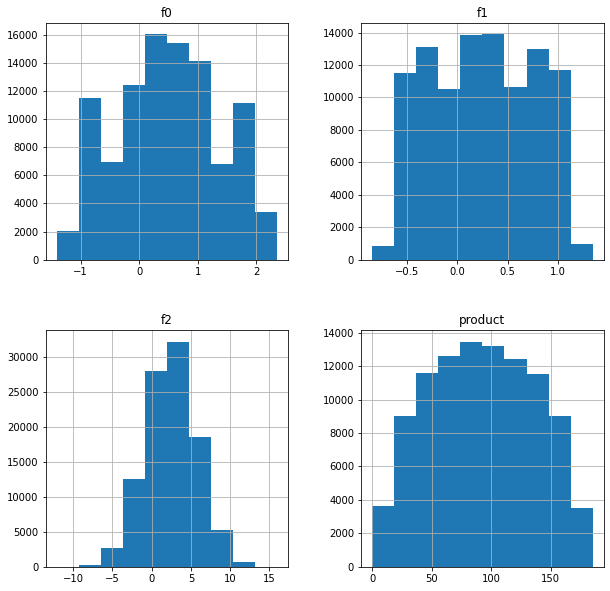

In [10]:
geo_1.hist(figsize = (10, 10))
plt.show()

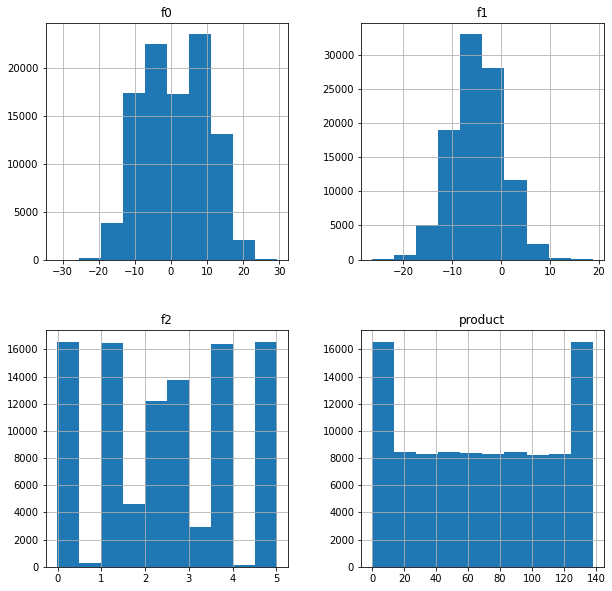

In [11]:
geo_2.hist(figsize = (10, 10))
plt.show()

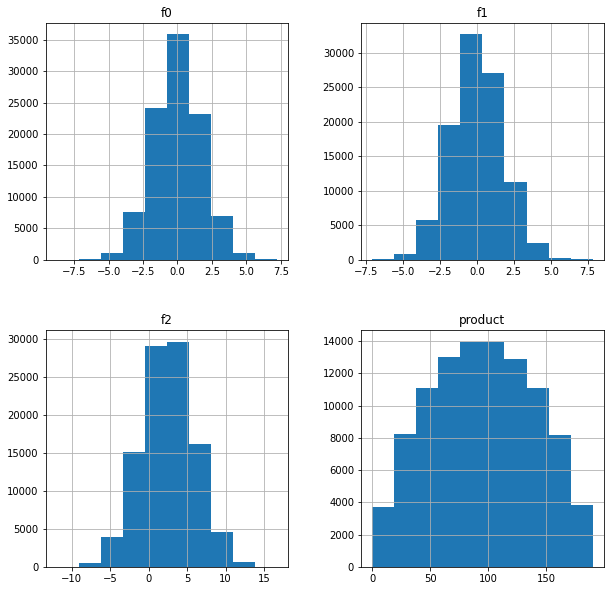

In [12]:
geo_3.hist(figsize = (10, 10))
plt.show()

На данном этапе выбросов или явных аномалий в данных не выявлено. При дальнейшем рассмотрении в пункте анализ данных будут сделаны выводы о распределениях

### Анализ данных

In [13]:
def hist_and_boxplot(df, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Гистограмма
    sns.histplot(df[col_name], ax=axes[0], bins = 10)
    axes[0].set_title(f'Гистограмма: {col_name}')
    axes[0].set_xlabel(f'Значения "{col_name}"')
    axes[0].set_ylabel('Частота')

    # Диаграмма размаха
    sns.boxplot(x=df[col_name], ax=axes[1])
    axes[1].set_title(f'Диаграмма размаха: {col_name}')
    axes[1].set_xlabel(f'Значения "{col_name}"')

    plt.tight_layout()
    plt.show()

#### Исследовательский анализ

Так как в данном проекте заказчиком были предоставлены данные по признакам f0, f1, f2, которые явялются технически специфическими (мы не знаем, что им свойственно и как корректнее с ними работать), в данном пункте мы рассмотрим лишь признак product

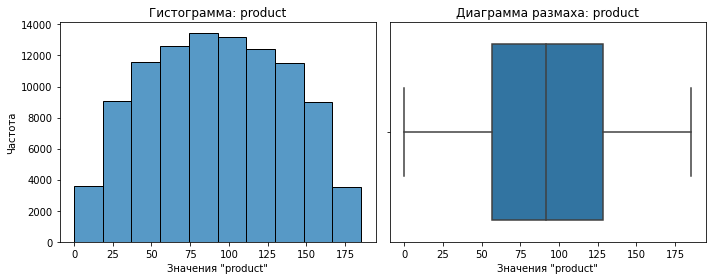

In [14]:
hist_and_boxplot(geo_1, 'product')

* Тип распределения: Близкое к нормальному с легкой правосторонней асимметрией
* Диапазон значений: 0-175
* Пик распределения: Около 100

**Характеристики:**

1. Относительно симметричное распределение
2. Умеренная вариативность
3. Небольшое количество выбросов

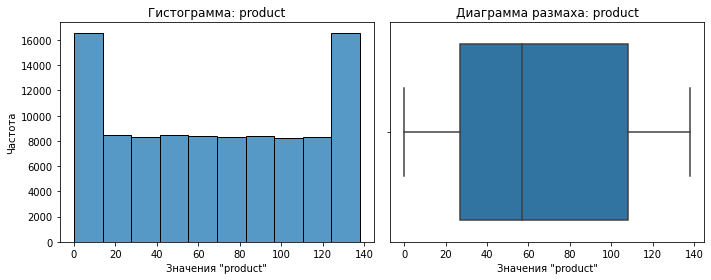

In [15]:
hist_and_boxplot(geo_2, 'product')

* Тип распределения: Бимодальное U-образное распределение
* Диапазон значений: 0-140


**Особенности:**

1. Два явных пика: один в районе 0-20, другой в районе 120-140
2. Провал в середине: очень мало наблюдений в диапазоне 40-100
3. Боксплот показывает широкий межквартильный размах

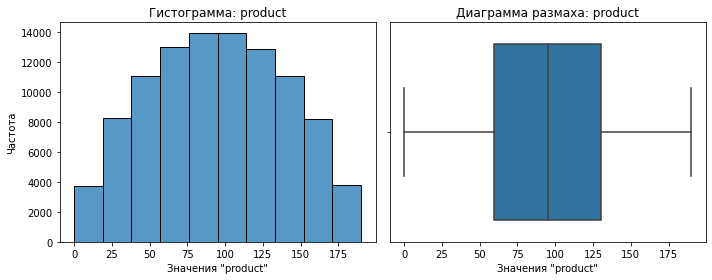

In [16]:
hist_and_boxplot(geo_3, 'product')

* Тип распределения: Нормальное с легкой левосторонней асимметрией
* Диапазон значений: 0-175
* Пик распределения: Около 100-110


**Характеристики:**

* Очень похоже на geo_1, но с небольшим смещением влево
1. Симметричное распределение
2. Умеренная вариативность

Добавим также график, который будет содержать все значения всех регионов для явного сопоставления

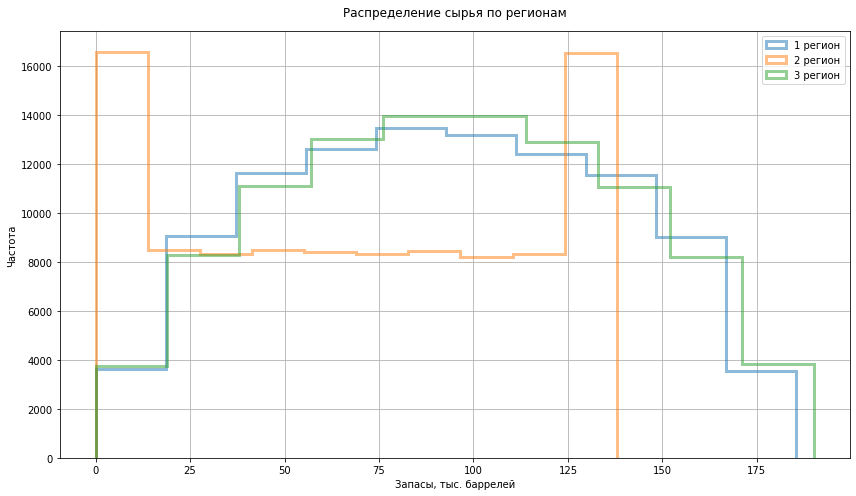

In [17]:
plt.figure(figsize=(12, 7))
ax = geo_1['product'].plot(kind='hist', grid=True, alpha=0.5, histtype='step', linewidth=3, label='1 регион')
geo_2['product'].plot(kind='hist', grid=True, alpha=0.5, histtype='step', linewidth=3, label='2 регион', ax=ax)
geo_3['product'].plot(kind='hist', grid=True, alpha=0.5, histtype='step', linewidth=3, label='3 регион', ax=ax)
plt.title('Распределение сырья по регионам', pad=15)
plt.xlabel('Запасы, тыс. баррелей')
plt.ylabel('Частота')
plt.legend()
plt.tight_layout()
plt.show()

#### Корреляционный анализ

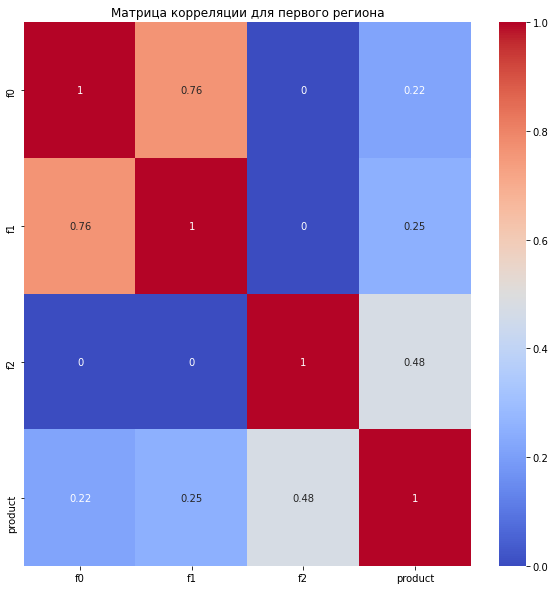

In [18]:
interval_cols = ['f0', 'f1', 'f2', 'product']

corr_matrix = geo_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции для первого региона')
plt.show()

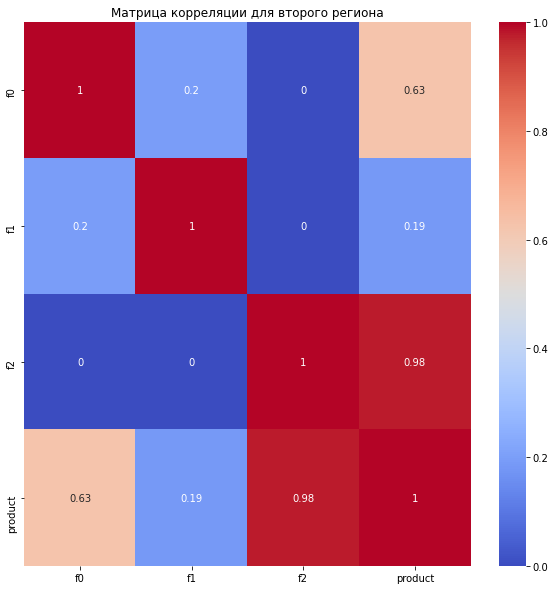

In [19]:
interval_cols = ['f0', 'f1', 'f2', 'product']

corr_matrix = geo_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции для второго региона')
plt.show()

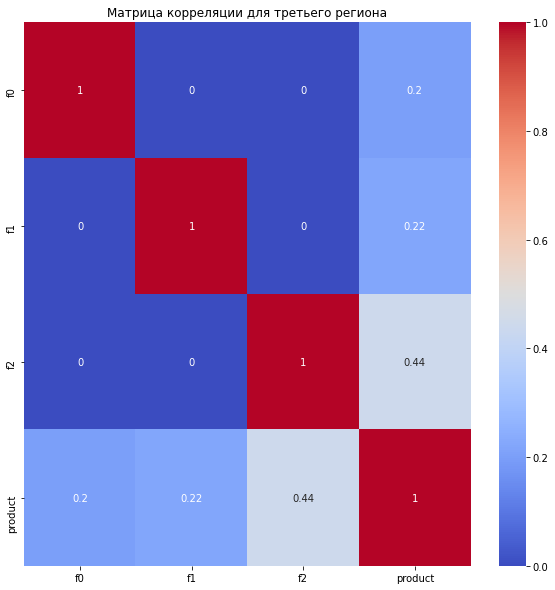

In [20]:
interval_cols = ['f0', 'f1', 'f2', 'product']

corr_matrix = geo_3.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции для третьего региона')
plt.show()

**Первый регион (geo_1)**

1. Сильная корреляция между f0 и f1 (0.76) - эти переменные тесно связаны
2. Слабые корреляции с product: f0 (0.22), f1 (0.25), f2 (0.48)
3. Наиболее предсказуемая переменная для product: f2

**Второй регион (geo_2)**

1. Сильная корреляция f2 с product (0.98) - почти функциональная зависимость
2. Умеренная корреляция f0 с product (0.63)
3. Слабая корреляция f1 с product (0.19)

**Третий регион (geo_3)**

1. Умеренные корреляции с product: f0 (0.2), f1 (0.22), f2 (0.44)
2. Наиболее сбалансированные, но слабые взаимосвязи

### Подготовка данных

Подготовку данных и обучение моделей будем выполнять с помощью функции

In [21]:
def process_and_evaluate(df, columns_to_scale, target_col = 'product', test_size=0.25, random_state =RANDOM_STATE):
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    
    features = df.drop([target_col], axis=1)
    target = df[target_col]
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )
    scaler = StandardScaler()
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_valid[columns_to_scale] = scaler.transform(X_valid[columns_to_scale])
    

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = RMSE(y_valid, predictions)
    
    return y_valid, predictions, rmse

In [22]:
#def scale_columns_inplace(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    #scaler = StandardScaler()
    #df[columns] = scaler.fit_transform(df[columns])
    #return df

#geo_1 = geo_1.drop('id', axis = 1)
#geo_2 = geo_2.drop('id', axis = 1)
#geo_3 = geo_3.drop('id', axis = 1)

Теперь разобьем наши данные на тренировочную и валидационную выборки

In [23]:
#target_1=geo_1['product']
#features_1=geo_1.drop(['product'], axis=1)

#target_2=geo_2['product']
#features_2=geo_2.drop(['product'], axis=1)

#target_3=geo_3['product']
#features_3=geo_3.drop(['product'], axis=1)

In [24]:
#X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=42)
#X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=42)
#X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(features_3, target_3, test_size=0.25, random_state=42)

#features_list = [X_train_1, X_train_2, X_train_3, 
                #X_valid_1, X_valid_2, X_valid_3]

#for features in features_list:
 #   scale_columns_inplace(features, ['f0', 'f1', 'f2'])

## Обучение и проверка модели

### Обучение модели для регионов

In [25]:
datasets = [geo_1, geo_2, geo_3]
columns_to_scale = ['f0', 'f1', 'f2']

results = []
for i, df in enumerate(datasets, 1):
    y_valid, predictions, rmse = process_and_evaluate(df, columns_to_scale)
    results.append({
        'dataset': f'geo_{i}',
        'y_valid': y_valid,
        'predictions': predictions,
        'rmse': rmse
    })
    print(f'Среднеквадратичная ошибка RMSE для датасета {i}: {rmse:.2f}')

y_valid_1, predict_1, rmse_1 = results[0]['y_valid'], results[0]['predictions'], results[0]['rmse']
y_valid_2, predict_2, rmse_2 = results[1]['y_valid'], results[1]['predictions'], results[1]['rmse']
y_valid_3, predict_3, rmse_3 = results[2]['y_valid'], results[2]['predictions'], results[1]['rmse']

Среднеквадратичная ошибка RMSE для датасета 1: 37.69
Среднеквадратичная ошибка RMSE для датасета 2: 0.89
Среднеквадратичная ошибка RMSE для датасета 3: 40.08


In [26]:
#model_1=LinearRegression()
#model_1.fit(X_train_1,y_train_1)
#predict_1=model_1.predict(X_valid_1)
#rmse_1 = rmse(y_valid_1, predict_1)
#print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_1)

In [27]:
#model_2=LinearRegression()
#model_2.fit(X_train_2,y_train_2)
#predict_2=model_2.predict(X_valid_2)
#rmse_2 = rmse(y_valid_2, predict_2)
#print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)

In [28]:
#model_3=LinearRegression()
#model_3.fit(X_train_3,y_train_3)
#predict_3=model_3.predict(X_valid_3)
#rmse_3 = rmse(y_valid_3, predict_3)
#print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_3)

Предсказания и правильные ответы сохранены в переменных predict_1\y_valid_1 для первого региона и для остальных в аналогичных перемнных с отличающейся цифрой

### Оценка модели

In [29]:
table = pd.DataFrame(index=['среднее предсказанное сырье','средние целевые значения','RMSE модели'], 
                     columns=['1 регион','2 регион','3 регион'])

table['1 регион'] = [predict_1.mean(), geo_1['product'].mean(), rmse_1]
table['2 регион'] = [predict_2.mean(), geo_2['product'].mean(), rmse_2]
table['3 регион'] = [predict_3.mean(), geo_3['product'].mean(), rmse_3]
table

,1 регион,2 регион,3 регион
среднее предсказанное сырье,92.609840,68.577035,94.934787
средние целевые значения,92.499684,68.823916,94.998342
RMSE модели,37.685089,0.892827,0.892827


### Выводы по разделу

Модели обучены и проверены на качество предсказания метрикой RMSE, которая определяет величину среднеквадратичной ошибки в предсказании модели. Исходя из полученных данный в нашей сводной таблицы, можно заметить, что величина RMSE во втором регионе сильно отличается от двух других, это связано с тем, что модель обучилась на практически равных по величине данных.

## Подготовка к расчёту прибыли

 ### Оценка скважин

Перед началом данного пункта важно вспомнить условия задачи:

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Все ключевые значения будут записаны в единой размености - в тысячах рублей

In [30]:
develop_budget = 10**7
profit_per_product = 450
losses_prob = 0.025

mean_geo_1=geo_1['product'].mean()
mean_geo_2=geo_2['product'].mean()
mean_geo_3=geo_3['product'].mean()

mean_geo_1_pred=predict_1.mean()
mean_geo_2_pred=predict_2.mean()
mean_geo_3_pred=predict_3.mean()

budget_for_one = develop_budget //200
prod_for_profit=budget_for_one//450
print(f'Бюджет на разработку одной скважины {budget_for_one} тысяч рублей')
print(f'Необходимое количество сырья для безубыточной добычи - {prod_for_profit} тысяч баррелей')

Бюджет на разработку одной скважины 50000 тысяч рублей
Необходимое количество сырья для безубыточной добычи - 111 тысяч баррелей


Мы получили, сколько стоит разработка одной точки, а это значит, что для безубыточной добычи нефти нужно выбрать точки, принощие больше, чем данное значение. 

**Чтобы точка была безубыточна, нужно, чтобы она приносила больше чем 50 миллионов рублей \ чтобы с нее добывалось более 111 тысяч баррелей**

In [31]:
#Сразу вопрос к ревьюверу. Сравнивать надо с предсказанным или с фактическим количеством сырья? В коде сделаю оба

table_profit = pd.DataFrame(index=['Средняя доходность по предсказанию в тыс.','Средняя доходность по фактическим данным в тыс.',
                                   'ROI % предсказанного', 'ROI % фактического'], 
                            columns=['1 регион','2 регион','3 регион'])

table_profit['1 регион'] = [predict_1.mean()*profit_per_product, 
                            mean_geo_1*profit_per_product,
                           (predict_1.mean()*profit_per_product-budget_for_one)/budget_for_one*100,
                           (mean_geo_1*profit_per_product-budget_for_one)/budget_for_one*100]
table_profit['2 регион'] = [predict_2.mean()*profit_per_product, 
                            mean_geo_2*profit_per_product,
                           (predict_2.mean()*profit_per_product-budget_for_one)/budget_for_one*100,
                           (mean_geo_2*profit_per_product-budget_for_one)/budget_for_one*100]
table_profit['3 регион'] = [predict_3.mean()*profit_per_product, 
                            mean_geo_3*profit_per_product,
                           (predict_3.mean()*profit_per_product-budget_for_one)/budget_for_one*100,
                           (mean_geo_3*profit_per_product-budget_for_one)/budget_for_one*100]
table_profit

,1 регион,2 регион,3 регион
Средняя доходность по предсказанию в тыс.,41674.428124,30859.665544,42720.654250
Средняя доходность по фактическим данным в тыс.,41624.857898,30970.762163,42749.253954
ROI % предсказанного,-16.651144,-38.280669,-14.558691
ROI % фактического,-16.750284,-38.058476,-14.501492


*Еще одно примечание для ревьювера. Я сделал разбор с позиции денег, а не баррелей. Так можно? Ниже сделаю для продукта*

In [32]:
table_profit_prod = pd.DataFrame(index=['Средняя доходность по предсказанию в тыс.','Средняя доходность по фактическим данным в тыс.',
                                   'ROI % предсказанного', 'ROI % фактического'], 
                            columns=['1 регион','2 регион','3 регион'])

table_profit_prod['1 регион'] = [predict_1.mean(), 
                            mean_geo_1,
                           (predict_1.mean()-prod_for_profit)/prod_for_profit*100,
                           (mean_geo_1-prod_for_profit)/prod_for_profit*100]
table_profit_prod['2 регион'] = [predict_2.mean(), 
                            mean_geo_2,
                           (predict_2.mean()-prod_for_profit)/prod_for_profit*100,
                           (mean_geo_2-prod_for_profit)/prod_for_profit*100]
table_profit_prod['3 регион'] = [predict_3.mean(), 
                            mean_geo_3,
                           (predict_3.mean()-prod_for_profit)/prod_for_profit*100,
                           (mean_geo_3-prod_for_profit)/prod_for_profit*100]
table_profit_prod

,1 регион,2 регион,3 регион
Средняя доходность по предсказанию в тыс.,92.609840,68.577035,94.934787
Средняя доходность по фактическим данным в тыс.,92.499684,68.823916,94.998342
ROI % предсказанного,-16.567711,-38.218888,-14.473165
ROI % фактического,-16.666951,-37.996472,-14.415908


### Выводы

Исходя из полученных данных очевидно, что среднее количество запасов сырья по регионам недостаточно даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами

## Функция для рассчета прибыли

Выберем 200 скважин в каждом регионе с наибольшей производительностью и посчитаем доходность для них. Так как у нас задача выбирать точки, добавим к предсказаниям айди каждой скважины

In [33]:
def profitability(predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*profit_per_product)-develop_budget
    print(f'Суммарный запас сырья в {count} лучших скважинах составит: {selected_max} тыс.баррелей')
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [34]:
print('Для первого региона: \n')
profitability(predict_1, y_valid_1, 200)

Для первого региона: 

Суммарный запас сырья в 200 лучших скважинах составит: 31007.790875603365 тыс.баррелей
Прибыль для полученного объёма сырья составит 3953.51 млн.рублей


In [35]:
print('Для первого региона: \n')
profitability(predict_2, y_valid_2, 200)

Для первого региона: 

Суммарный запас сырья в 200 лучших скважинах составит: 27740.13406331368 тыс.баррелей
Прибыль для полученного объёма сырья составит 2483.06 млн.рублей


In [36]:
print('Для первого региона: \n')
profitability(predict_3, y_valid_3, 200)

Для первого региона: 

Суммарный запас сырья в 200 лучших скважинах составит: 29607.797309825037 тыс.баррелей
Прибыль для полученного объёма сырья составит 3323.51 млн.рублей


In [37]:
#Переделка функции под дальнейшее использование

def profitability(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * profit_per_product
    return revenue - develop_budget

**Вывод**

Все три региона потенциально прибыльные, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка проведём расчёт вероятности

## Расчёт прибыли и рисков 

In [38]:
def bootstrap_1000(target,predict, reg):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profitability(probs_subsample,target_subsample, 200)) 
        if values[-1] < 0:
            count +=1
            
    values = pd.Series(values)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title(f'Распределение прибыли в {reg}')
    values.plot(kind="hist", grid=True, figsize=(10,10))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    print(f"Средняя прибыль: {values.mean()/1000} млн.руб")
    print(f"95%-ый доверительный интервал: от {(confidence_interval[0]/1000)} млн.руб до {(confidence_interval[1]/1000)} млн.руб")
    print(f'Процент вероятности убытка в данном регионе составит {count/10}%')

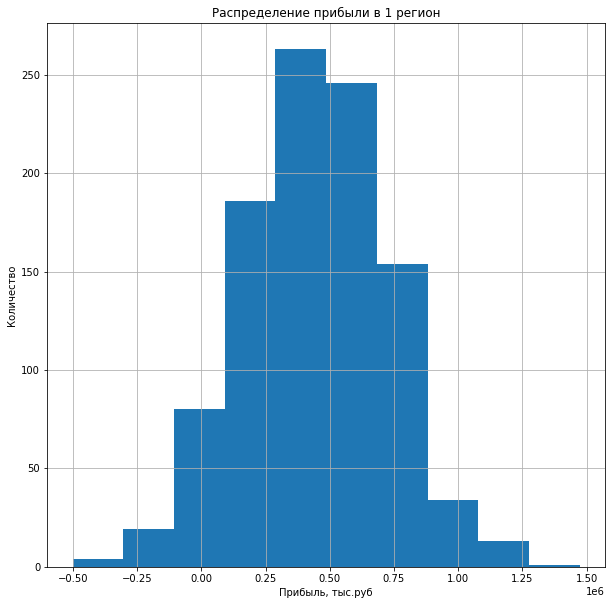

Средняя прибыль: 447.530184813157 млн.руб
95%-ый доверительный интервал: от 430.17770524017544 млн.руб до 464.88266438613863 млн.руб
Процент вероятности убытка в данном регионе составит 5.3%


In [39]:
bootstrap_1000(y_valid_1, predict_1, '1 регион')

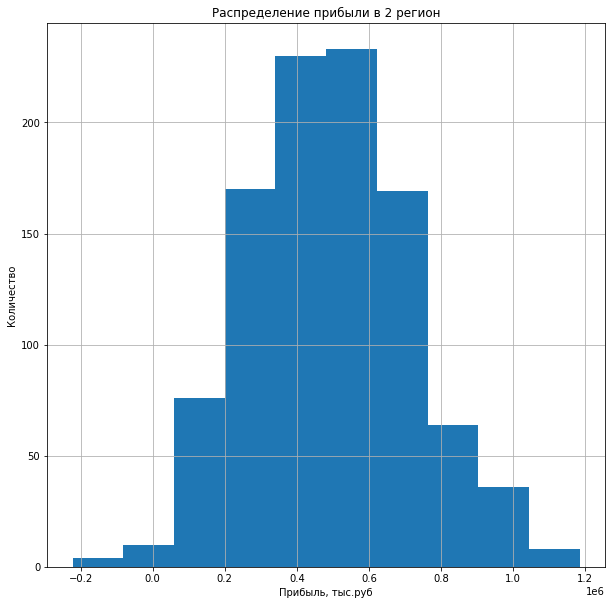

Средняя прибыль: 491.06852563676466 млн.руб
95%-ый доверительный интервал: от 477.2512491531045 млн.руб до 504.8858021204248 млн.руб
Процент вероятности убытка в данном регионе составит 0.7%


In [40]:
bootstrap_1000(y_valid_2, predict_2, '2 регион')

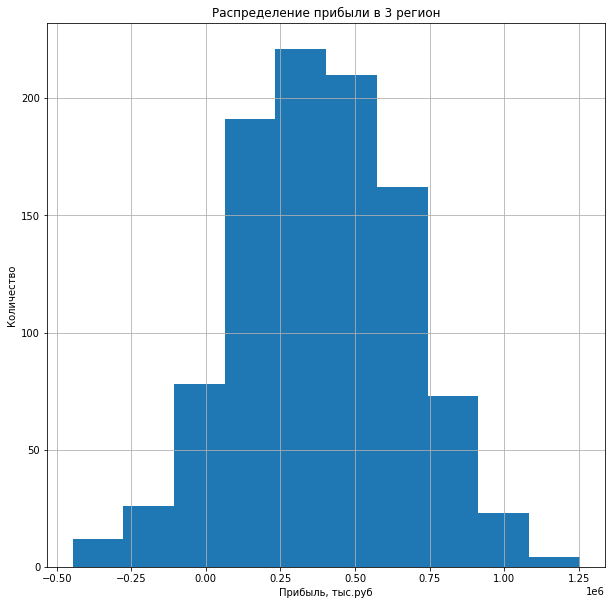

Средняя прибыль: 383.78604012672315 млн.руб
95%-ый доверительный интервал: от 366.41936194792885 млн.руб до 401.1527183055175 млн.руб
Процент вероятности убытка в данном регионе составит 7.8%


In [41]:
bootstrap_1000(y_valid_3, predict_3, '3 регион')

## Выводы

Мы получили информацию о рисках и прибыли для каждого из регионов. Так получилось, что условию (вероятность убытков должна быть меньше 2.5%) удовлетворяет **только второй регион**, несмотря на свои сравнительно малые запасы.

В контексте бизнес задачи можно дать две рекоммендации:
1. Для крупного и стабильного бизнеса, как у заказчика, рациональнее выбрать скважины втрого региона, так как они сулят наиболее стабильную доходность
2. В другом контексте можно было бы порекомендовать первый регион, так как по соотношению риски\максимальная доходность, он выше. Для реализации эффективной добычи в нем может потребоваться дополнительное исследование